In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import optuna
import joblib


In [2]:
dataset = pd.read_csv('../../data/australia_rain/australia_rain.csv')
dataset.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# Create new feature - Month
def get_month(date):
    return int(date[5:7])

dataset['month'] = dataset['Date'].apply(get_month)

In [4]:
missing = dataset['RainTomorrow'].isnull()
dataset.drop(dataset[missing].index, inplace=True)

In [5]:
for column in dataset.columns:
    print(dataset[column].isna().sum(), len(dataset), column)

0 142193 Date
0 142193 Location
637 142193 MinTemp
322 142193 MaxTemp
1406 142193 Rainfall
60843 142193 Evaporation
67816 142193 Sunshine
9330 142193 WindGustDir
9270 142193 WindGustSpeed
10013 142193 WindDir9am
3778 142193 WindDir3pm
1348 142193 WindSpeed9am
2630 142193 WindSpeed3pm
1774 142193 Humidity9am
3610 142193 Humidity3pm
14014 142193 Pressure9am
13981 142193 Pressure3pm
53657 142193 Cloud9am
57094 142193 Cloud3pm
904 142193 Temp9am
2726 142193 Temp3pm
1406 142193 RainToday
0 142193 RainTomorrow
0 142193 month


In [6]:
numeric_columns = dataset._get_numeric_data().columns
categorical_columns = list(set(dataset.columns) - set(numeric_columns))
print(numeric_columns)
print(categorical_columns)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'month'],
      dtype='object')
['WindDir9am', 'RainTomorrow', 'WindDir3pm', 'Location', 'RainToday', 'Date', 'WindGustDir']


In [7]:
for column in categorical_columns:
    nan_count = dataset[column].isna().sum()
    distribution = dataset[column].value_counts(normalize=True)
    missing = dataset[column].isnull()
    dataset.loc[missing, column] = np.random.choice(distribution.index, size=len(dataset[missing]), p=distribution.values)

In [8]:
for column in numeric_columns:
    dataset[column] = dataset[column].fillna(dataset[column].median())

<Axes: >

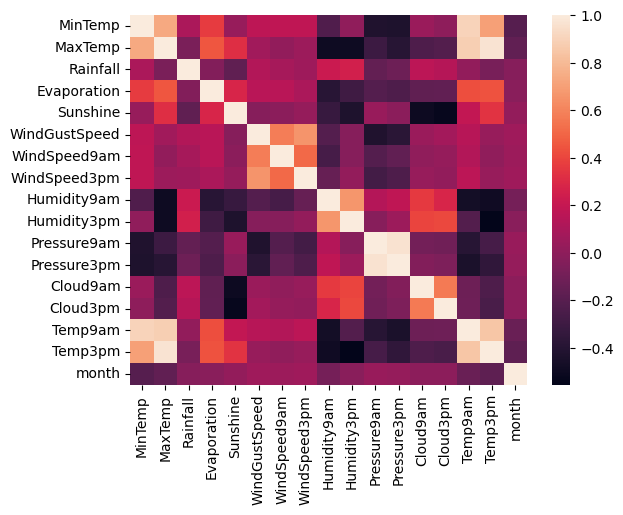

In [9]:
corr_matrix = dataset[numeric_columns].corr()
sns.heatmap(corr_matrix)

<Axes: >

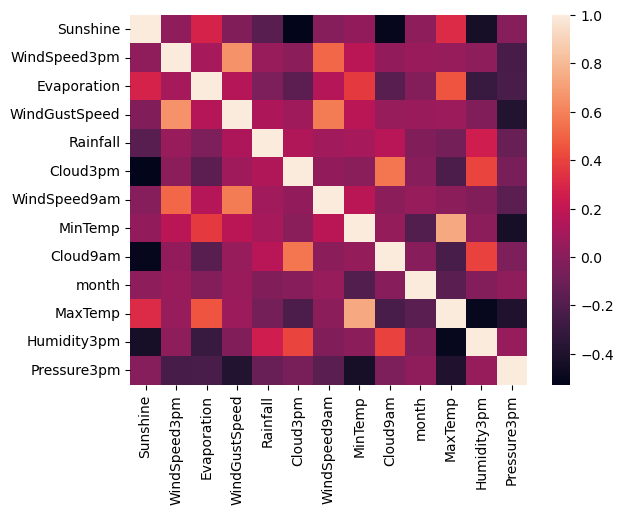

In [10]:
numeric_columns = list(set(numeric_columns) - {'Temp9am', 'Temp3pm', 'Pressure9am', 'Humidity9am'})
corr_matrix = dataset[numeric_columns].corr()
sns.heatmap(corr_matrix)

In [11]:
columns_to_delete = {'Temp9am', 'Temp3pm', 'Pressure9am', 'Humidity9am'}
new_columns = list(set(dataset.columns) - columns_to_delete)
dataset = dataset[new_columns]

In [12]:
dataset.head()

,WindGustSpeed,Rainfall,MinTemp,Cloud9am,WindGustDir,Humidity3pm,WindDir9am,RainTomorrow,WindDir3pm,Sunshine,WindSpeed3pm,Evaporation,Location,Cloud3pm,RainToday,month,WindSpeed9am,Date,MaxTemp,Pressure3pm
0,44.0,0.6,13.4,8.0,W,22.0,W,No,WNW,8.5,24.0,4.8,Albury,5.0,No,12,20.0,2008-12-01,22.9,1007.1
1,44.0,0.0,7.4,5.0,WNW,25.0,NNW,No,WSW,8.5,22.0,4.8,Albury,5.0,No,12,4.0,2008-12-02,25.1,1007.8
2,46.0,0.0,12.9,5.0,WSW,30.0,W,No,WSW,8.5,26.0,4.8,Albury,2.0,No,12,19.0,2008-12-03,25.7,1008.7
3,24.0,0.0,9.2,5.0,NE,16.0,SE,No,E,8.5,9.0,4.8,Albury,5.0,No,12,11.0,2008-12-04,28.0,1012.8
4,41.0,1.0,17.5,7.0,W,33.0,ENE,No,NW,8.5,20.0,4.8,Albury,8.0,No,12,7.0,2008-12-05,32.3,1006.0


c:\ML\anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ML\anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ML\anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ML\anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ML\anaconda\L

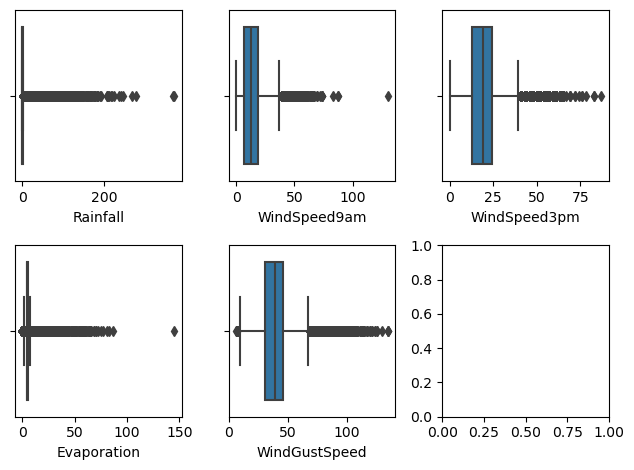

In [13]:
# Detecting outliers
fig, axs = plt.subplots(2, 3)
sns.boxplot(x="Rainfall", data=dataset, ax=axs[0, 0])
sns.boxplot(x="WindSpeed9am", data=dataset, ax=axs[0, 1])
sns.boxplot(x="WindSpeed3pm", data=dataset, ax=axs[0, 2])
sns.boxplot(x="Evaporation", data=dataset, ax=axs[1, 0])
sns.boxplot(x="WindGustSpeed", data=dataset, ax=axs[1, 1])
fig.tight_layout()
plt.show()

In [14]:
print(f'{len(dataset)} - Length of dataset before removing outliers')
# Removing outliers
dataset = dataset.drop(dataset[dataset.Rainfall > 200].index)
dataset = dataset.drop(dataset[dataset.WindSpeed9am > 40].index)
dataset = dataset.drop(dataset[dataset.WindSpeed3pm > 45].index)
dataset = dataset.drop(dataset[dataset.Evaporation > 20].index)
dataset = dataset.drop(dataset[dataset.WindGustSpeed > 85].index)
print(f'{len(dataset)} - Length of dataset after removing outliers')

142193
139238


In [ ]:
dataset = dataset.replace({'RainTomorrow': {'No': 0, 'Yes': 1}, 'RainToday': {'No': 0, 'Yes': 1}})
dataset = dataset.drop('Date', axis=1)

In [18]:
X = dataset.drop('RainTomorrow', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, dataset['RainTomorrow'], test_size=0.1, random_state=42)

In [19]:
dataset.head()

,Rainfall,MinTemp,Cloud9am,WindGustDir,Humidity3pm,WindDir9am,RainTomorrow,WindDir3pm,Sunshine,WindSpeed3pm,Evaporation,Location,Cloud3pm,RainToday,month,WindSpeed9am,MaxTemp,Pressure3pm
WindGustSpeed,,,,,,,,,,,,,,,,,,
44.0,0.6,13.4,8.0,W,22.0,W,0,WNW,8.5,24.0,4.8,Albury,5.0,0,12,20.0,22.9,1007.1
44.0,0.0,7.4,5.0,WNW,25.0,NNW,0,WSW,8.5,22.0,4.8,Albury,5.0,0,12,4.0,25.1,1007.8
46.0,0.0,12.9,5.0,WSW,30.0,W,0,WSW,8.5,26.0,4.8,Albury,2.0,0,12,19.0,25.7,1008.7
24.0,0.0,9.2,5.0,NE,16.0,SE,0,E,8.5,9.0,4.8,Albury,5.0,0,12,11.0,28.0,1012.8
41.0,1.0,17.5,7.0,W,33.0,ENE,0,NW,8.5,20.0,4.8,Albury,8.0,0,12,7.0,32.3,1006.0


In [20]:
ordinal_encoder = OrdinalEncoder()
numeric_columns = X_train._get_numeric_data().columns
categorical_columns = list(set(X_train.columns) - set(numeric_columns))
X_train[categorical_columns] = ordinal_encoder.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = ordinal_encoder.transform(X_test[categorical_columns])

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
class MyBaggingClassifier(BaseEstimator):
    def __init__(self, base_classifier=DecisionTreeClassifier(max_depth=1), n_estimators=50):
        self.base_classifier = base_classifier
        self.n_estimators = n_estimators
        self.classifiers = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_train = X[indices]
            y_train = y[indices]

            classifier = self.base_classifier.__class__()
            classifier.fit(X_train, y_train)

            self.classifiers.append(classifier)

    def predict(self, X):
        predictions = [classifier.predict(X) for classifier in self.classifiers]
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

        return majority_votes

In [23]:
class MyAdaBoost(BaseEstimator):
    def __init__(self, base_classifier=DecisionTreeClassifier(), n_estimators=50):
        self.base_classifier = base_classifier
        self.n_estimators = n_estimators
        self.classifiers = []
        self.weights = []
        self.classifier_weights = []
        self.regularization = 1e-4

    def _initialize_params(self, X):
        weights = np.zeros((len(X)))
        weight_val = float(1) / len(X)
        for i in range(len(X)):
            weights[i] = weight_val
        self.weights = weights
        self.classifier_weights = np.zeros(self.n_estimators)

    def _update_weights(self, X_train, y_train, classifier, i):
        predictions = classifier.predict(X_train)
        correct_mask = np.equal(y_train, predictions)
        incorrect_mask = np.logical_not(np.equal(y_train, predictions))
        total_error = np.sum(self.weights[incorrect_mask])
        classifier_weight = 0.5 * np.log((1 - total_error) / (total_error + self.regularization))
        self.classifier_weights[i] = classifier_weight

        self.weights[incorrect_mask] = self.weights[incorrect_mask] * np.exp(
            -classifier_weight
        )
        self.weights[correct_mask] = self.weights[correct_mask] * np.exp(
            classifier_weight
        )

        self.weights = self.weights / np.sum(self.weights)

    def fit(self, X_train, y_train):
        self._initialize_params(X_train)
        for i in range(self.n_estimators):
            classifier = self.base_classifier.__class__()
            classifier.fit(X_train, y_train)
            self._update_weights(X_train, y_train, classifier, i)

            self.classifiers.append(classifier)
    
    def predict(self, X):
        num_samples = X.shape[0]
        num_classes = np.max([clf.predict(X).max() for clf in self.classifiers]) + 1
        weighted_sum_predictions = np.zeros((num_samples, num_classes))
        
        for classifier, weight in zip(self.classifiers, self.classifier_weights):
            predictions = classifier.predict(X)
            for i in range(num_samples):
                weighted_sum_predictions[i, predictions[i]] += weight

        final_predictions = np.argmax(weighted_sum_predictions, axis=1)

        return final_predictions

In [25]:
dc = DecisionTreeClassifier(max_depth=1)
y_train_np = y_train.to_numpy()

In [26]:
parameters = {'n_estimators':np.arange(2, 102, step=20, dtype=int)}
clf = GridSearchCV(MyBaggingClassifier(), parameters, scoring='f1')
clf.fit(X_train_scaled, y_train_np)
print(clf.best_score_, clf.best_params_)

0.5966882103885279 {'n_estimators': 62}


In [27]:
parameters = {'n_estimators':np.arange(2, 102, step=20, dtype=int)}
clf = GridSearchCV(MyAdaBoost(), parameters, scoring='f1')
clf.fit(X_train_scaled, y_train_np)
print(clf.best_score_, clf.best_params_)

0.519725028601058 {'n_estimators': 62}


In [ ]:
def objective_rf(trial):
    split_criterion = trial.suggest_categorical('split_criterion', ['gini', 'entropy', 'log_loss'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16, log=True)
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
    n_estimators = trial.suggest_int('n_estimators', 2, 64, log=True)
    classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split,
                                            criterion=split_criterion, random_state=0)

    score = cross_val_score(classifier_obj, X_train_scaled, y_train, n_jobs=-1, cv=3, scoring='f1')
    f1 = score.mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=50)

In [ ]:
joblib.dump(study, 'random_forest_study.pkl')

In [65]:
study = joblib.load("random_forest_study.pkl")
best_params = dict()
best_params['random_forest'] = study.best_trial.params

print(f'F1 of best classifier - {study.best_value}')
print('Parameters of this classifier:')
print(study.best_trial.params)
elapsed_s = (study.trials[-1].datetime_complete - study.trials[0].datetime_start).total_seconds()
print(f'Elapsed time - {elapsed_s} seconds')

F1 of best classifier - 0.6060735010338291
Parameters of this classifier:
{'split_criterion': 'log_loss', 'min_samples_split': 2, 'rf_max_depth': 28, 'n_estimators': 61}
Elapsed time - 673.605948 seconds


In [22]:
def objective_adaboost(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e5, log=True)
    split_criterion = trial.suggest_categorical('split_criterion', ['gini', 'entropy', 'log_loss'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16, log=True)
    dc_max_depth = trial.suggest_int('dc_max_depth', 2, 32, log=True)
    n_estimators = trial.suggest_int('n_estimators', 2, 64, log=True)
    dc = DecisionTreeClassifier(max_depth=dc_max_depth, criterion=split_criterion, min_samples_split=min_samples_split)
    classifier_obj = AdaBoostClassifier(dc, n_estimators=n_estimators, learning_rate=learning_rate, random_state=0)

    score = cross_val_score(classifier_obj, X_train_scaled, y_train, n_jobs=-1, cv=3, scoring='f1')
    f1 = score.mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective_adaboost, n_trials=50)

[I 2024-03-16 15:57:14,570] A new study created in memory with name: no-name-8662e62f-cc5e-419c-8441-d83cc0b7d2b0
[I 2024-03-16 15:57:20,618] Trial 0 finished with value: 0.5576125125783284 and parameters: {'learning_rate': 96144.73827282958, 'split_criterion': 'gini', 'min_samples_split': 4, 'dc_max_depth': 6, 'n_estimators': 13}. Best is trial 0 with value: 0.5576125125783284.
[I 2024-03-16 15:57:24,576] Trial 1 finished with value: 0.2684675487760208 and parameters: {'learning_rate': 101.41053164526816, 'split_criterion': 'entropy', 'min_samples_split': 5, 'dc_max_depth': 3, 'n_estimators': 8}. Best is trial 0 with value: 0.5576125125783284.
[I 2024-03-16 15:57:28,506] Trial 2 finished with value: 0.5042494191723034 and parameters: {'learning_rate': 6.57349512878893e-05, 'split_criterion': 'log_loss', 'min_samples_split': 15, 'dc_max_depth': 3, 'n_estimators': 2}. Best is trial 0 with value: 0.5576125125783284.
[I 2024-03-16 15:58:25,897] Trial 3 finished with value: 0.5830137008526

In [23]:
joblib.dump(study, 'adaboost_sklearn_study.pkl')

['adaboost_study.pkl']

In [66]:
study = joblib.load("adaboost_sklearn_study.pkl")
best_params['adaboost_sklearn'] = study.best_trial.params

print(f'F1 of best classifier - {study.best_value}')
print('Parameters of this classifier:')
print(study.best_trial.params)
elapsed_s = (study.trials[-1].datetime_complete - study.trials[0].datetime_start).total_seconds()
print(f'Elapsed time - {elapsed_s} seconds')

F1 of best classifier - 0.6046483836686897
Parameters of this classifier:
{'learning_rate': 0.010424320939180113, 'split_criterion': 'entropy', 'min_samples_split': 11, 'dc_max_depth': 16, 'n_estimators': 39}
Elapsed time - 2446.121135 seconds


In [29]:
def objective_histgrad(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e5, log=True)
    max_iter = trial.suggest_int('max_iter', 1, 200)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 40)
    dc_max_depth = trial.suggest_int('dc_max_depth', 2, 32, log=True)
    l2_coeff = trial.suggest_float('l2_coeff', 0, 1)
    classifier_obj = HistGradientBoostingClassifier(max_depth=dc_max_depth, min_samples_leaf=min_samples_leaf,
                                                    l2_regularization=l2_coeff, max_iter=max_iter,
                                                    learning_rate=learning_rate, random_state=0)

    score = cross_val_score(classifier_obj, X_train_scaled, y_train, n_jobs=-1, cv=3, scoring='f1')
    f1 = score.mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective_histgrad, n_trials=50)

[I 2024-03-16 16:44:04,032] A new study created in memory with name: no-name-931ec928-6a69-4d72-87f6-c70cbfb3e76d
[I 2024-03-16 16:44:11,540] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 5.982573734035186e-05, 'max_iter': 134, 'min_samples_leaf': 30, 'dc_max_depth': 25, 'l2_coeff': 0.05483388285458979}. Best is trial 0 with value: 0.0.
[I 2024-03-16 16:44:15,438] Trial 1 finished with value: 0.5740754022087927 and parameters: {'learning_rate': 0.09500738463432949, 'max_iter': 124, 'min_samples_leaf': 3, 'dc_max_depth': 2, 'l2_coeff': 0.2726828984869206}. Best is trial 1 with value: 0.5740754022087927.
[I 2024-03-16 16:44:16,372] Trial 2 finished with value: 0.5788576167428133 and parameters: {'learning_rate': 2008.0330339163852, 'max_iter': 139, 'min_samples_leaf': 11, 'dc_max_depth': 4, 'l2_coeff': 0.6204256882830982}. Best is trial 2 with value: 0.5788576167428133.
[I 2024-03-16 16:44:19,490] Trial 3 finished with value: 0.6226516249682637 and parameters: {'lear

In [30]:
joblib.dump(study, 'histgrad_study.pkl')

['histgrad_study.pkl']

In [67]:
study = joblib.load("histgrad_study.pkl")
best_params['histgrad'] = study.best_trial.params

print(f'F1 of best classifier - {study.best_value}')
print('Parameters of this classifier:')
print(study.best_trial.params)
elapsed_s = (study.trials[-1].datetime_complete - study.trials[0].datetime_start).total_seconds()
print(f'Elapsed time - {elapsed_s} seconds')

F1 of best classifier - 0.6259294535767118
Parameters of this classifier:
{'learning_rate': 0.2173774476217424, 'max_iter': 83, 'min_samples_leaf': 26, 'dc_max_depth': 7, 'l2_coeff': 0.2324669111596357}
Elapsed time - 160.589412 seconds


In [90]:
def objective_gradboost(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e5, log=True)
    loss = trial.suggest_categorical('loss', ['log_loss', 'exponential'])
    max_features = trial.suggest_int('max_features', 1, 5)
    n_estimators = trial.suggest_int('n_estimators', 2, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16, log=True)
    dc_max_depth = trial.suggest_int('dc_max_depth', 2, 32, log=True)
    subsample = trial.suggest_float('subsample', 1e-5, 1)
    classifier_obj = GradientBoostingClassifier(loss=loss, max_depth=dc_max_depth, min_samples_split=min_samples_split,
                                                subsample=subsample, max_features=max_features, n_estimators=n_estimators,
                                                learning_rate=learning_rate, random_state=0)

    score = cross_val_score(classifier_obj, X_train_scaled, y_train, n_jobs=-1, cv=3, scoring='f1')
    f1 = score.mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective_gradboost, n_trials=50)

[I 2024-04-01 18:23:59,343] A new study created in memory with name: no-name-02f2d675-77b6-4cdd-8df5-44844e424a16
[I 2024-04-01 18:24:05,272] Trial 0 finished with value: 0.2605122252769423 and parameters: {'learning_rate': 107.00249018485846, 'loss': 'log_loss', 'max_features': 5, 'n_estimators': 11, 'min_samples_split': 9, 'dc_max_depth': 4, 'subsample': 0.07299111743786238}. Best is trial 0 with value: 0.2605122252769423.
[I 2024-04-01 18:24:34,067] Trial 1 finished with value: 0.43568628754421157 and parameters: {'learning_rate': 58.22525457611429, 'loss': 'exponential', 'max_features': 4, 'n_estimators': 43, 'min_samples_split': 5, 'dc_max_depth': 20, 'subsample': 0.8197684373603672}. Best is trial 1 with value: 0.43568628754421157.
[I 2024-04-01 18:25:02,462] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 9.604665567853489e-05, 'loss': 'exponential', 'max_features': 5, 'n_estimators': 13, 'min_samples_split': 13, 'dc_max_depth': 19, 'subsample': 0.980629498671

In [91]:
joblib.dump(study, 'gradboost_study.pkl')

['gradboost_study.pkl']

In [92]:
study = joblib.load("gradboost_study.pkl")
best_params['gradboost'] = study.best_trial.params

print(f'F1 of best classifier - {study.best_value}')
print('Parameters of this classifier:')
print(study.best_trial.params)
elapsed_s = (study.trials[-1].datetime_complete - study.trials[0].datetime_start).total_seconds()
print(f'Elapsed time - {elapsed_s} seconds')

F1 of best classifier - 0.6070869806697502
Parameters of this classifier:
{'learning_rate': 0.041014104222826454, 'loss': 'log_loss', 'max_features': 5, 'n_estimators': 98, 'min_samples_split': 8, 'dc_max_depth': 12, 'subsample': 0.8783407243770347}
Elapsed time - 8868.814619 seconds


In [36]:
def objective_bagging(trial):
    max_samples = trial.suggest_float('max_samples', 1e-3, 1, log=True)
    split_criterion = trial.suggest_categorical('split_criterion', ['gini', 'entropy', 'log_loss'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16, log=True)
    dc_max_depth = trial.suggest_int('dc_max_depth', 2, 32, log=True)
    n_estimators = trial.suggest_int('n_estimators', 2, 64, log=True)
    dc = DecisionTreeClassifier(max_depth=dc_max_depth, criterion=split_criterion, min_samples_split=min_samples_split)
    classifier_obj = BaggingClassifier(dc, n_estimators=n_estimators, max_samples=max_samples, random_state=0)

    score = cross_val_score(classifier_obj, X_train_scaled, y_train, n_jobs=-1, cv=3, scoring='f1')
    f1 = score.mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective_bagging, n_trials=50)

[I 2024-04-01 12:05:46,447] A new study created in memory with name: no-name-95a5748f-3076-4c28-98a5-3565561ac20f
[I 2024-04-01 12:05:51,167] Trial 0 finished with value: 0.4742374119208936 and parameters: {'max_samples': 0.03639119660225958, 'split_criterion': 'entropy', 'min_samples_split': 3, 'dc_max_depth': 11, 'n_estimators': 2}. Best is trial 0 with value: 0.4742374119208936.
[I 2024-04-01 12:06:03,204] Trial 1 finished with value: 0.598568007672771 and parameters: {'max_samples': 0.23336411174321942, 'split_criterion': 'log_loss', 'min_samples_split': 4, 'dc_max_depth': 19, 'n_estimators': 33}. Best is trial 1 with value: 0.598568007672771.
[I 2024-04-01 12:06:05,409] Trial 2 finished with value: 0.4518493740837914 and parameters: {'max_samples': 0.0751218338350263, 'split_criterion': 'entropy', 'min_samples_split': 2, 'dc_max_depth': 26, 'n_estimators': 2}. Best is trial 1 with value: 0.598568007672771.
[I 2024-04-01 12:06:08,304] Trial 3 finished with value: 0.5157326817448018

In [37]:
joblib.dump(study, 'bagging_sklearn_study.pkl')

['bagging_sklearn_study.pkl']

In [69]:
study = joblib.load("bagging_sklearn_study.pkl")
best_params['bagging_sklearn'] = study.best_trial.params

print(f'F1 of best classifier - {study.best_value}')
print('Parameters of this classifier:')
print(study.best_trial.params)
elapsed_s = (study.trials[-1].datetime_complete - study.trials[0].datetime_start).total_seconds()
print(f'Elapsed time - {elapsed_s} seconds')

F1 of best classifier - 0.6054145982726248
Parameters of this classifier:
{'max_samples': 0.7086911166839754, 'split_criterion': 'log_loss', 'min_samples_split': 14, 'dc_max_depth': 21, 'n_estimators': 48}
Elapsed time - 554.470757 seconds


In [38]:
def objective_lgb(trial):
    dtrain = lgb.Dataset(X_train_scaled, label=y_train)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test_scaled)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_test, pred_labels)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective_lgb, n_trials=50)

[I 2024-04-01 12:16:42,797] A new study created in memory with name: no-name-b06f0d63-33c6-4ee5-83b8-b601eb4d0279
[I 2024-04-01 12:16:44,189] Trial 0 finished with value: 0.6447198076567411 and parameters: {'lambda_l1': 7.873290782620297e-05, 'lambda_l2': 0.002756572708881433, 'num_leaves': 186, 'feature_fraction': 0.45937094681369217, 'bagging_fraction': 0.6424048025156667, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.6447198076567411.
[I 2024-04-01 12:16:45,178] Trial 1 finished with value: 0.6367165834719911 and parameters: {'lambda_l1': 5.174685926794426e-06, 'lambda_l2': 5.8129565492044174e-05, 'num_leaves': 99, 'feature_fraction': 0.9968465456891396, 'bagging_fraction': 0.8991852557524538, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 0 with value: 0.6447198076567411.
[I 2024-04-01 12:16:46,083] Trial 2 finished with value: 0.6387648809523809 and parameters: {'lambda_l1': 0.00043720209894417727, 'lambda_l2': 0.0004894618304760413, 'num_l

In [39]:
joblib.dump(study, 'lgb_study.pkl')

['lgb_study.pkl']

In [70]:
study = joblib.load("lgb_study.pkl")
best_params['lgb'] = study.best_trial.params

print(f'F1 of best classifier - {study.best_value}')
print('Parameters of this classifier:')
print(study.best_trial.params)
elapsed_s = (study.trials[-1].datetime_complete - study.trials[0].datetime_start).total_seconds()
print(f'Elapsed time - {elapsed_s} seconds')

F1 of best classifier - 0.6504872219157933
Parameters of this classifier:
{'lambda_l1': 0.08250099070157656, 'lambda_l2': 1.8774535324355115, 'num_leaves': 250, 'feature_fraction': 0.4757775905755668, 'bagging_fraction': 0.5159614895766673, 'bagging_freq': 3, 'min_child_samples': 66}
Elapsed time - 80.556878 seconds


In [40]:
def objective_catboost(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(X_test_scaled)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_test, pred_labels)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective_catboost, n_trials=50)

[I 2024-04-01 12:24:17,893] A new study created in memory with name: no-name-66d6cbee-43e3-4fd9-8cd7-3ce4df3c01a1
[I 2024-04-01 12:25:24,576] Trial 0 finished with value: 0.592966776763163 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05547001933242553, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5082824564234023}. Best is trial 0 with value: 0.592966776763163.
[I 2024-04-01 12:25:39,661] Trial 1 finished with value: 0.6324466092169352 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09395858218582974, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.6324466092169352.
[I 2024-04-01 12:25:53,640] Trial 2 finished with value: 0.6223304608467591 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0726305991413242, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.515883307785027}. Best is trial 1 with value: 0

In [41]:
joblib.dump(study, 'catboost_study.pkl')

['catboost_study.pkl']

In [71]:
study = joblib.load("catboost_study.pkl")
best_params['catboost'] = study.best_trial.params

print(f'F1 of best classifier - {study.best_value}')
print('Parameters of this classifier:')
print(study.best_trial.params)
elapsed_s = (study.trials[-1].datetime_complete - study.trials[0].datetime_start).total_seconds()
print(f'Elapsed time - {elapsed_s} seconds')

F1 of best classifier - 0.6465773809523809
Parameters of this classifier:
{'objective': 'Logloss', 'colsample_bylevel': 0.09289341208816582, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
Elapsed time - 1575.187582 seconds


In [43]:
def objective_xgboost(trial):
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dvalid = xgb.DMatrix(X_test_scaled, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_test, pred_labels)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=150)

[I 2024-04-01 12:58:41,537] A new study created in memory with name: no-name-dff88048-e051-424e-a2ed-00ef96cc3110
[I 2024-04-01 12:58:41,832] Trial 0 finished with value: 0.47031858812743527 and parameters: {'booster': 'dart', 'lambda': 1.2242886621692218e-07, 'alpha': 0.23852611540085616, 'subsample': 0.2461155069168604, 'colsample_bytree': 0.48576868708531973, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.18366774527981813, 'gamma': 3.2233567596675553e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00038382015391401586, 'skip_drop': 9.221472289885694e-05}. Best is trial 0 with value: 0.47031858812743527.
[I 2024-04-01 12:58:42,092] Trial 1 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 0.00032652943320117376, 'alpha': 0.0002348255270357713, 'subsample': 0.5989234767674827, 'colsample_bytree': 0.6105667356376565, 'max_depth': 3, 'min_child_weight': 10, 'eta': 1.8619445979657294e-06, 'gamma': 7.610880120473

In [44]:
joblib.dump(study, 'xgboost_study.pkl')

['xgboost_study.pkl']

In [72]:
study = joblib.load("xgboost_study.pkl")
best_params['xgboost'] = study.best_trial.params

print(f'F1 of best classifier - {study.best_value}')
print('Parameters of this classifier:')
print(study.best_trial.params)
elapsed_s = (study.trials[-1].datetime_complete - study.trials[0].datetime_start).total_seconds()
print(f'Elapsed time - {elapsed_s} seconds')

F1 of best classifier - 0.578515550467468
Parameters of this classifier:
{'booster': 'gblinear', 'lambda': 0.0003548889599559324, 'alpha': 1.8937254641375437e-07, 'subsample': 0.4597973254000508, 'colsample_bytree': 0.23238557445969313}
Elapsed time - 29.530754 seconds


LightGBM classifier was the best with F1 score = 0.65

Now it's time for confusion matrices

In [82]:
def print_matrix(y_pred, y_test):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    plt.show()

c:\ML\anaconda\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:14:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytree", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


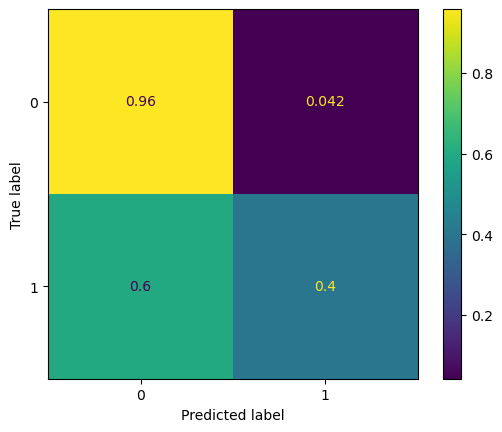

In [83]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dvalid = xgb.DMatrix(X_test_scaled, label=y_test)
xgb_classifier = xgb.train(best_params['xgboost'], dtrain)
preds = xgb_classifier.predict(dvalid)
y_pred = np.rint(preds)
print_matrix(y_pred, y_test)

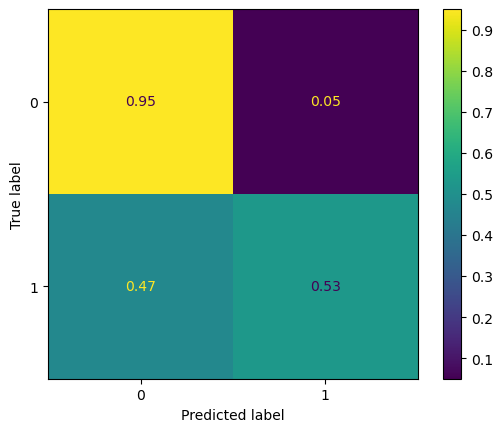

In [84]:
gbm = cb.CatBoostClassifier(**best_params['catboost'])
gbm.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=0, early_stopping_rounds=100)
preds = gbm.predict(X_test_scaled)
pred_labels = np.rint(preds)
print_matrix(pred_labels, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 125314, number of used features: 17
[LightGBM] [Info] Start training from score 0.220223


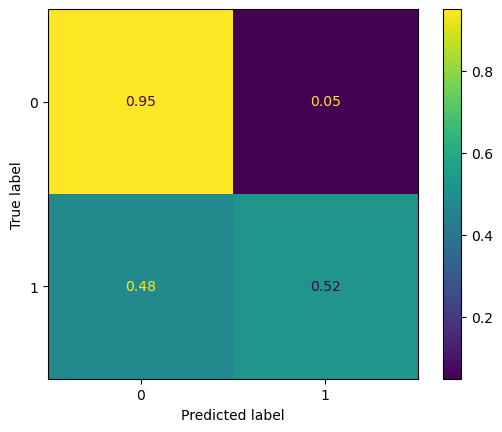

In [86]:
dtrain = lgb.Dataset(X_train_scaled, label=y_train)

gbm = lgb.train(best_params['lgb'], dtrain)
preds = gbm.predict(X_test_scaled)
pred_labels = np.rint(preds)
print_matrix(pred_labels, y_test)

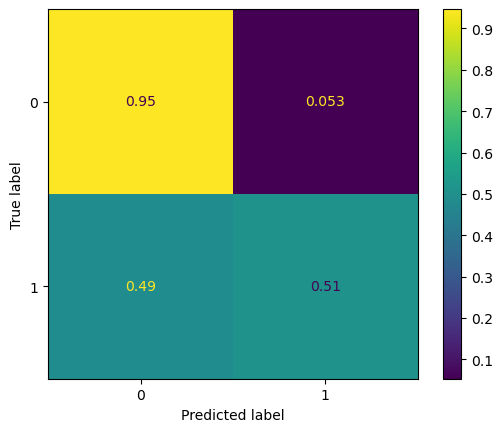

In [88]:
bagging_params = best_params['bagging_sklearn']

dc = DecisionTreeClassifier(max_depth=bagging_params['dc_max_depth'], criterion=bagging_params['split_criterion'], min_samples_split=bagging_params['min_samples_split'])
classifier_obj = BaggingClassifier(dc, n_estimators=bagging_params['n_estimators'], max_samples=bagging_params['max_samples'], random_state=0)
classifier_obj.fit(X_train_scaled, y_train)
pred_labels = classifier_obj.predict(X_test_scaled)
print_matrix(pred_labels, y_test)

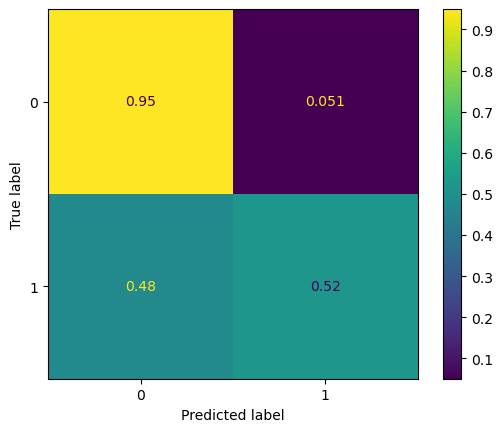

In [93]:
gradboost_params = best_params['gradboost']

classifier_obj = GradientBoostingClassifier(loss=gradboost_params['loss'], max_depth=gradboost_params['dc_max_depth'], min_samples_split=gradboost_params['min_samples_split'],
                                            subsample=gradboost_params['subsample'], max_features=gradboost_params['max_features'], n_estimators=gradboost_params['n_estimators'],
                                            learning_rate=gradboost_params['learning_rate'], random_state=0)
classifier_obj.fit(X_train_scaled, y_train)
pred_labels = classifier_obj.predict(X_test_scaled)
print_matrix(pred_labels, y_test)

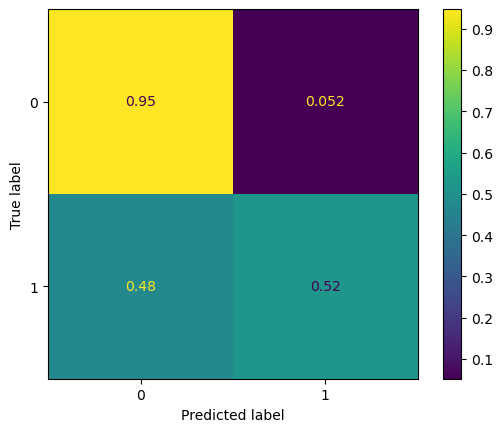

In [94]:
histgrad_params = best_params['histgrad']

classifier_obj = HistGradientBoostingClassifier(max_depth=histgrad_params['dc_max_depth'], min_samples_leaf=histgrad_params['min_samples_leaf'],
                                                l2_regularization=histgrad_params['l2_coeff'], max_iter=histgrad_params['max_iter'],
                                                learning_rate=histgrad_params['learning_rate'], random_state=0)
classifier_obj.fit(X_train_scaled, y_train)
pred_labels = classifier_obj.predict(X_test_scaled)
print_matrix(pred_labels, y_test)

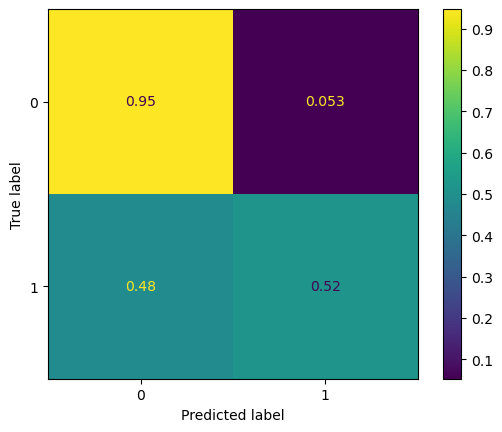

In [95]:
adaboost_params = best_params['adaboost_sklearn']

dc = DecisionTreeClassifier(max_depth=adaboost_params['dc_max_depth'], criterion=adaboost_params['split_criterion'], min_samples_split=adaboost_params['min_samples_split'])
classifier_obj = AdaBoostClassifier(dc, n_estimators=adaboost_params['n_estimators'], learning_rate=adaboost_params['learning_rate'], random_state=0)
classifier_obj.fit(X_train_scaled, y_train)
pred_labels = classifier_obj.predict(X_test_scaled)
print_matrix(pred_labels, y_test)

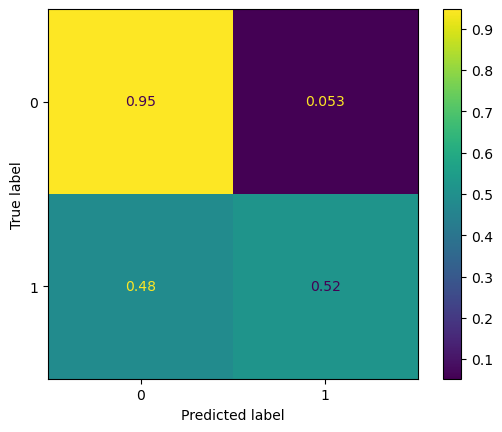

In [97]:
rf_params = best_params['random_forest']

classifier_obj = RandomForestClassifier(max_depth=rf_params['rf_max_depth'], n_estimators=rf_params['n_estimators'], min_samples_split=rf_params['min_samples_split'],
                                        criterion=rf_params['split_criterion'], random_state=0)
classifier_obj.fit(X_train_scaled, y_train)
pred_labels = classifier_obj.predict(X_test_scaled)
print_matrix(pred_labels, y_test)

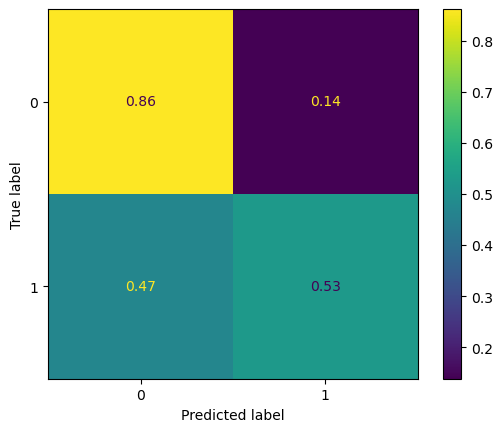

In [98]:
classifier_obj = MyAdaBoost(n_estimators=60)
classifier_obj.fit(X_train_scaled, y_train)
pred_labels = classifier_obj.predict(X_test_scaled)
print_matrix(pred_labels, y_test)

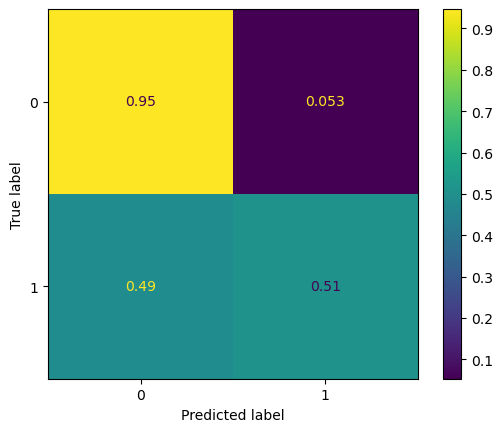

In [100]:
classifier_obj = MyBaggingClassifier(n_estimators=60)
classifier_obj.fit(X_train_scaled, y_train_np)
pred_labels = classifier_obj.predict(X_test_scaled)
print_matrix(pred_labels, y_test)

Вывод - практически все классификаторы справились с задачей одинаково.

Они успешно различают обеъекты первого класса, но довольно плохо справляются со вторым.

Также стоит заметить, что объектов второго класса намного меньше, чем первого, т.к. в Австралии, по-видимому, дожди происходят редко.